c:\Users\zhzjh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zhzjh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\zhzjh\AppData\Local\Temp\ipykernel_8928\2037538177.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 

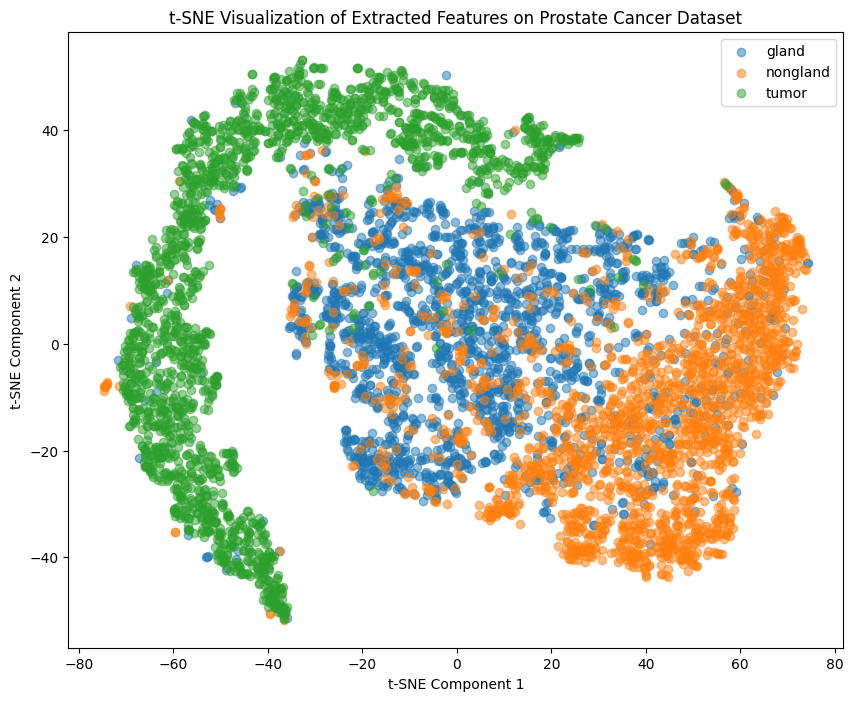

In [3]:
import torch
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class CustomResNet18(torch.nn.Module):
    def __init__(self, num_classes=3):
        super(CustomResNet18, self).__init__()
        resnet = models.resnet18(pretrained=False)  
        self.features = torch.nn.Sequential(*list(resnet.children())[:-1])  

    def forward(self, x):
        x = self.features(x)  
        x = x.view(x.size(0), -1)  
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomResNet18(num_classes=3).to(device)
model.load_state_dict(torch.load('final_feature_resnet18.pth'),strict=False) 
model.eval()  


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset2_path = './Dataset2/ProstateCancer'
dataset2 = datasets.ImageFolder(root=dataset2_path, transform=transform)
data_loader2 = DataLoader(dataset2, batch_size=32, shuffle=False, num_workers=4)

def extract_features(data_loader, model):
    model.eval()  
    features, labels = [], []
    with torch.no_grad():
        for images, label in data_loader:
            images = images.to(device) 
            output = model(images)  
            features.append(output.cpu().numpy()) 
            labels.append(label.numpy())  
    features = np.concatenate(features)  
    labels = np.concatenate(labels)  
    return features, labels


features2, labels2 = extract_features(data_loader2, model)


tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features2)


plt.figure(figsize=(10, 8))
for label in np.unique(labels2):
    idx = labels2 == label
    plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], label=dataset2.classes[label], alpha=0.5)
plt.legend()
plt.title("t-SNE Visualization of Extracted Features on Prostate Cancer Dataset")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features2, labels2, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Feature-based classification accuracy: {accuracy * 100:.2f}%")


Feature-based classification accuracy: 93.50%
